In [2]:
import scprep
scprep.io.download.download_google_drive('1VuddKA7Xa23NAFKvRUmtuND16eEMHL9z', '/content/r_packages.tar.gz')
!tar xzf /content/r_packages.tar.gz && rm /content/r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!echo "R_LIBS_USER='/content/.r_packages'" >> ~/.Renviron

tar (child): /content/r_packages.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
/usr/bin/sh: apt-get: command not found


In [3]:
import pandas as pd
import numpy as np
import phate
import scprep
import magic

import matplotlib.pyplot as plt
import seaborn as sns

import time, os, tarfile

import anndata, scanpy
# matplotlib settings for Jupyter notebooks only
%matplotlib inline

sns.set_style('ticks')

## Comparing trajectory inference algorithms on Treutlein fibroblast data

In this exercise, we will run both Diffusion Pseudotime and Slingshot on a dataset of 392 cells generated from trans-differentiating fibroblasts from [Treutlein et al. _Nature_. 2016](http://doi.org/10.1038/nature18323). This data was already preprocessed and downloaded from the [Dynverse quickstart tutorial](https://dynverse.org/users/2-quick_start/).

Briefly, a variety of transcription factors were overexpressed in Mouse Embryonic Fibroblasts (MEFs) to induce neuronal differentiation. Cells were sampled at several intervals over 22 days of differentation and sequenced using the Fluidigm C1 system and the SMART-seq protocol.

Here, we're doing to work with data that has already been filtered, preprocessed, and normalized so we can get straight to work running trajectory inference algorithms. This preprocessing includes selection of 2000 highly variable genes so the data matrix is 392 cells by 2000 genes.

Unlike the previous exercise, we're going to use the Diffusion Psuedotime (DPT) and Slingshot implementations provided by the original authors of each paper. DPT is provided as part of the excellent [Scanpy](https://scanpy.readthedocs.io/en/stable/) single cell analysis toolkit. Slingshot is only available from the R implementation, so we provided a convenience wrapper in `scprep.run`.

We're breaking this section into the following parts. First, we'll run Slingshot on the Treutlein data. Next, we'll run diffusion pseudotime and compare the results.

## Loading and visualizing the data

#### Download data from Google Drive

In [4]:
home = os.path.expanduser('~')
download_path = os.path.join(home, 'scRNAseq', '2014_Treutlein_Fibroblast.tar.gz')

# Download the data tarball
if not os.path.exists(download_path):
    scprep.io.download.download_google_drive('1WzEva0PM95an9hKiwgQydV_df0P_g63Q',download_path)

# Extract data directory
tf = tarfile.open(download_path)
tf.extractall(os.path.dirname(download_path))

# Format the data paths
data_dir = os.path.join(os.path.dirname(download_path), '2014_Treutlein_Fibroblast_induced_neural_differentation')

data_path = os.path.join(data_dir, 'Treutlein.expression.csv')
metadata_path  = os.path.join(data_dir, 'Treutlein.groups.csv')

#### Read in the data using `pandas`

In [85]:
data = pd.read_csv(data_path, index_col=0)

metadata = pd.read_csv(metadata_path, index_col=0)
metadata.columns = pd.Index(['annotated_clusters'])

#### Run PHATE

In [8]:
phate_op = phate.PHATE(knn=5, n_jobs=-2)

data_phate = phate_op.fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 392 cells and 2000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.13 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.24 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 0.04 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 1.86 seconds.
Calculated PHATE in 2.16 seconds.


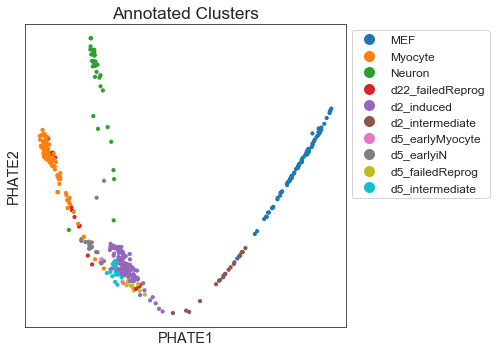

In [88]:
scprep.plot.scatter2d(data_phate, c=metadata['annotated_clusters'],
                      legend_anchor=(1,1),
                      label_prefix='PHATE', ticks=None,
                      title='Annotated Clusters',
                      figsize=(7,5))

## Running Slingshot

[Slingshot](https://doi.org/10.1186/s12864-018-4772-0) is a trajectory inference tool that was reported to be among the top-performing trajectory inference algorithms for simple trajectories. The method has five conceptual steps:

1. Perform dimensionality reduction on the data (e.g. PCA, PHATE, UMAP)
2. Cluster the data
3. Create a minimum spanning tree between the data
4. Fit principal curves to the data
5. Project the data onto the principal curves



### Step 1 - Perform dimensionality reduction

We already did this! For now, let's proceed to Step 2. If you have extra time later, try using a different dimensionality reduction algorithm by removing the comments at the beginning of the next code block.

In [10]:
# To run the next two lines, remove the hashtags at the beginning of each line
#data_umap = umap.UMAP().fit_transform(data)
#data_pca = scprep.reduce.pca(data, n_components=2)

### Step 2 - Cluster the data

Picking the ideal number of clusters here is a little trial and error. Let's try a few different number of clusters and compare.

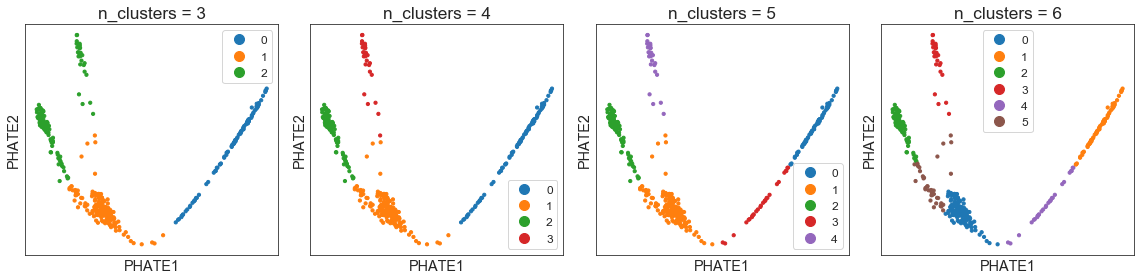

In [11]:
fig, axes = plt.subplots(1,4, figsize=(16,4))

ks = [3,4,5,6]
for i, ax in enumerate(axes):
    k = ks[i]
    # Run PHATE clustering
    clusters = phate.cluster.kmeans(phate_op, n_clusters=k)
    metadata['cluster'] = clusters
    scprep.plot.scatter2d(data_phate, c=metadata['cluster'],
                     title='n_clusters = {}'.format(k),
                     label_prefix='PHATE', ticks=None,
                          ax=ax)
    
fig.tight_layout()

#### Pick a number of clusters that looks good to you

We picked 4, but each pair should use a different number of clusters.

In [95]:
clusters = phate.cluster.kmeans(phate_op, n_clusters=4)
metadata['cluster'] = clusters

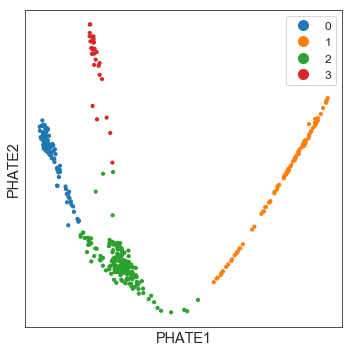

In [96]:
scprep.plot.scatter2d(data_phate, c=metadata['cluster'],
                 label_prefix='PHATE', ticks=None,
                figsize=(5,5))

### Step 3, 4, 5 - Create the minimum spanning tree, fit principal curves, and project data onto curves

These last steps of Slingshot are all performed behind-the-scenes by the Slingshot R package. We're going to leave all of those steps to Slingshot here and access the method using `scprep.run.Slingshot`. You can find the full documentation for the method here: https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.run

#### Run `scprep.run.Slingshot()`

In [97]:
results = scprep.run.Slingshot(data_phate, metadata['cluster'])

R[write to console]: Using full covariance matrix


#### Grab output from `results` dictionary

In [99]:
pseudotime = results['pseudotime']
metadata['slingshot1'] = pseudotime.iloc[:,0]
metadata['slingshot2'] = pseudotime.iloc[:,1]

metadata['slingshot_branch'] = results['branch']

#### Plotting the principal curves


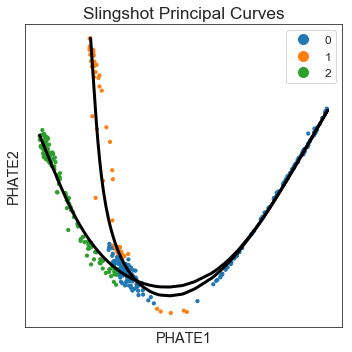

In [35]:
ax = scprep.plot.scatter2d(data_phate, c=metadata['slingshot_branch'],
                 label_prefix='PHATE', ticks=None,
                 title='Slingshot Principal Curves',
                 figsize=(5,5))

# `results['curves']` returns as tensor (an array of arrays)
# Each array contains coordinates for the curves in the dimensionality reduced space
for curve in results['curves']:
    ax.plot(curve[:,0], curve[:,1], c='k', linewidth=3)

### Plotting branch pseudotime

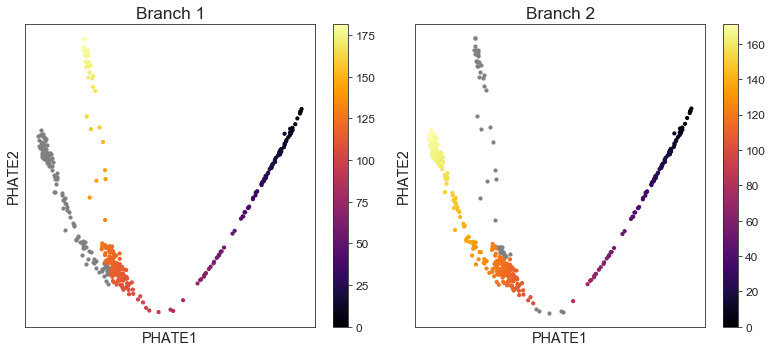

In [71]:
fig, axes = plt.subplots(1,2, figsize=(11,5))

for i, ax in enumerate(axes):
    curr_pseudotime = metadata['slingshot{}'.format(i+1)]
    m = ~pd.isnull(curr_pseudotime)
    # plot null points as grey
    scprep.plot.scatter2d(data_phate[~m], color='grey', s=10,
                          ax=ax)    
    # plot points on branch
    scprep.plot.scatter2d(data_phate[m], c=curr_pseudotime[m], s=10,
                         label_prefix='PHATE', ticks=None,
                          title='Branch {}'.format(i + 1),
                          ax=ax)
    
fig.tight_layout()

### Plotting clusters by pseudotime

Now we can do something interesting, like figure out the developmental ordering of the various cell types characterized in the `annotated_clusters` metadata variable.

To plot clusters by pseudotime, we're going to use `scprep.plot.jitterplot()`. Jitterplots are a kind of scatter plot useful for comparing the distribution of values within various classes of data. They are related to `sns.violinplot` and `sns.swarmplot`, but can be plotted much more quickly because the noise on the x-dimension is random Normal.

The grey circles in the center of each column are the means for those classes.

`scprep.plot.jitterplot` API: https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.plot  
Jitterplot gallery: https://scprep.readthedocs.io/en/stable/examples/jitter.html

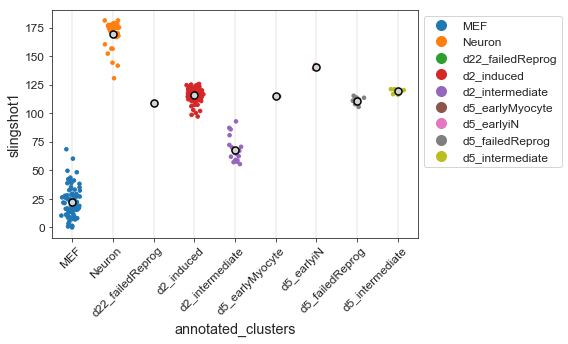

In [122]:
# Get all the cells that are on the desired branch.
curr_branch = 'slingshot1'
mask = ~pd.isnull(metadata[curr_branch])

# Create Jitterplot
ax = scprep.plot.jitter(metadata['annotated_clusters'].loc[mask], metadata[curr_branch].loc[mask],
                       c=metadata['annotated_clusters'].loc[mask], legend_anchor=(1,1),
                        means_s=50,
                       figsize=(8,4))

# Neaten xticklabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=0.15)

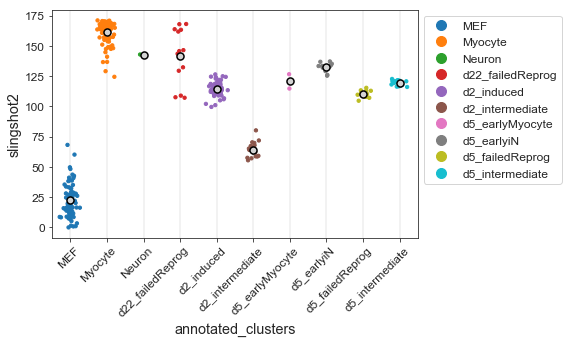

In [123]:
# Get all the cells that are on the desired branch.
curr_branch = 'slingshot2'
mask = ~pd.isnull(metadata[curr_branch])

# Create Jitterplot
ax = scprep.plot.jitter(metadata['annotated_clusters'].loc[mask], metadata[curr_branch].loc[mask],
                       c=metadata['annotated_clusters'].loc[mask], legend_anchor=(1,1),
                        means_s=50,
                       figsize=(8,4))

# Neaten xticklabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=0.15)

### Optional - variations on Slingshot

If you have extra time, try the following exercises:

1. What happens if you use UMAP, t-SNE, or PCA as input to Slingshot?
2. What happens if you use the original annotated clusters as input to Slingshot?

#### Breakpoint: if you're done, help those around you!

## Running Diffusion Pseudotime

In this section, we're going to use the diffusion pseudotime algorithm implemented in `scanpy`, a scRNA-seq analysis toolkit from Alex Wolf and the Theis Lab. The Theis lab were the inventors of the algorithm, so we're going to use their implementation to provide a comparison to Slingshot. As this MEF dataset is fairly simply, we don't expect to see huge differences between the algorithms. 

Because `scanpy` is a Python package, we can just use their code directly. The documentation for the `scanpy.tl.dpt` function can be found here: https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.tl.dpt.html.

#### About the  `AnnData` object

All of the `scanpy` functions expect data to be organized in an `AnnData` object. The idea behind `AnnData` is to have a single container for all of the data and metadata associated with a single cell experiment. The `AnnData` class is useful and flexible. We don't use the `AnnData` class elsewhere in the workshop because we prefer to directly interact with Pandas `DataFrame` objects which are a more generic data container. The `DataFrame` is a useful data container for almost any kind of data one might work with, while `AnnData` is designed around gene expression data.

You very well may find that you prefer working with `AnnData` objects because of the handy single-cell functionality built into `scanpy`. If you want to learn more about them, check out the official `AnnData` documentation here: https://anndata.readthedocs.io.

### Running DPT

The workflow here is fairly simple. We're going to put the data in an `Anndata` container, run PCA, calculate NearestNeighbors, and DiffusionMaps. With that done, we are ready to run DPT.

In [91]:
# Here we create an AnnData container
adata = anndata.AnnData(data)

# DPT requires a root cell, depending on the orientation of your
# plot, you should be able to use the cell with the highest 
# data_phate[:,0] coordinate
adata.uns['iroot'] = np.argmax(data_phate.iloc[:,0].values)

# Run PCA
scanpy.pp.pca(adata)

# Identify nearest neighbors
scanpy.pp.neighbors(adata)

# Create the diffusion map
scanpy.tl.diffmap(adata)

# Run Diffusion Pseudotime with 1 branching event
scanpy.tl.dpt(adata, n_branchings=1)

# Grab the output and store in our metadata DataFrame
metadata['dpt'] = adata.obs['dpt_pseudotime']
metadata['dpt_branch'] = adata.obs['dpt_groups'].astype(int)

### Plotting pseudotime and branch assignments

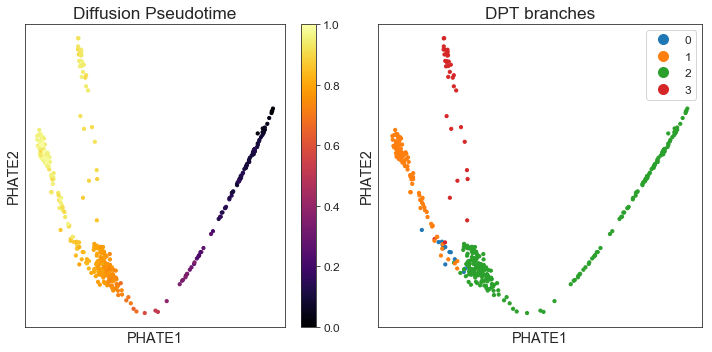

In [92]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

ax = scprep.plot.scatter2d(data_phate, c=metadata['dpt'], 
                           ticks=None, label_prefix='PHATE',
                           title='Diffusion Pseudotime',
                           ax=axes[0])

scprep.plot.scatter2d(data_phate, c=metadata['dpt_branch'], 
                      ticks=None, label_prefix='PHATE',
                      title='DPT branches',
                      legend_anchor=(1,1),
                     ax=axes[1])

fig.tight_layout()

#### Breakpoint: if you're done, help those around you!

## Plotting clusters by pseudotime

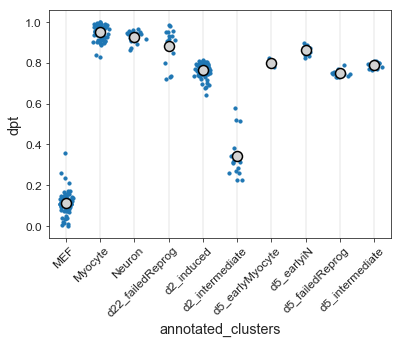

In [103]:
ax = scprep.plot.jitter(metadata['annotated_clusters'], metadata['dpt'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=0.15)

## Comparing DPT vs Slingshot

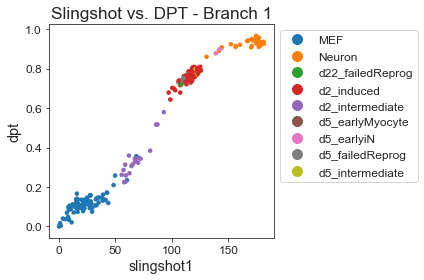

In [109]:
# Get all the cells that are on the desired branch.
curr_branch = 'slingshot1'
mask = ~pd.isnull(metadata[curr_branch])

ax = scprep.plot.scatter(metadata[curr_branch].loc[mask], metadata['dpt'].loc[mask],
                        c=metadata['annotated_clusters'].loc[mask],
                         title='Slingshot vs. DPT - Branch 1',
                        legend_anchor=(1,1))

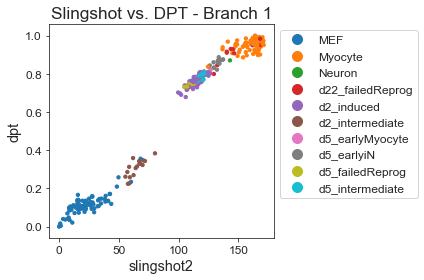

In [124]:
# Get all the cells that are on the desired branch.
curr_branch = 'slingshot2'
mask = ~pd.isnull(metadata[curr_branch])

ax = scprep.plot.scatter(metadata[curr_branch].loc[mask], metadata['dpt'].loc[mask],
                        c=metadata['annotated_clusters'].loc[mask],
                         title='Slingshot vs. DPT - Branch 1',
                        legend_anchor=(1,1))

### Optional - Plotting genes by pseudotime

Try plotting genes like `Vim`, `Fn1`, `Ascl1`, `Myl1`, or `Stemn3` against either slingshot or diffusion pseudotime. 

#### Breakpoint - Help others around you if you're done!